In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import neurodsp
from bycycle.features import compute_features
import os
import h5py
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

from config import config_dict

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/1'):
    os.makedirs('figs/1')

# A-B. Example LFP

In [3]:
# Load dataframe of cycle feature statistics for each shank
df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_shanks = df_shanks[df_shanks['burst_type']==0].reset_index()

# Load lfp
shank_idx = 0
rat, sess, sh, Fs, elec = df_shanks.loc[shank_idx, ['rat', 'sess', 'sh', 'Fs', 'elec']]

lfp_filename = config_dict['mat_path'] + rat + '/' + sess + '/' + str(sh) + '/lfp' + str(elec) + '.mat'
f = h5py.File(lfp_filename)
lfp = np.array(f['lfp']).T[0]
t = np.arange(0, len(lfp)/Fs, 1/Fs)

# Filter lfp
lfp_filt = neurodsp.filter(lfp, Fs, 'lowpass', fc=config_dict['cf_low'],
                           N_seconds=config_dict['N_seconds_low'], remove_edge_artifacts=False)
lfp_filt = neurodsp.filter(lfp_filt, Fs, 'highpass', fc=config_dict['cf_high'],
                      N_seconds=config_dict['N_seconds_high'], remove_edge_artifacts=False)

osc_kwargs = config_dict['burst_kwargs_list'][0]

# Compute shape
df = compute_features(lfp_filt, Fs, config_dict['f_range'],
                      center_extrema=config_dict['extrema_center'],
                      burst_detection_kwargs=osc_kwargs)

Transition bandwidth is 2.4 Hz. Pass/stop bandwidth is 25 Hz
Transition bandwidth is 0.0 Hz. Pass/stop bandwidth is 624.0 Hz


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


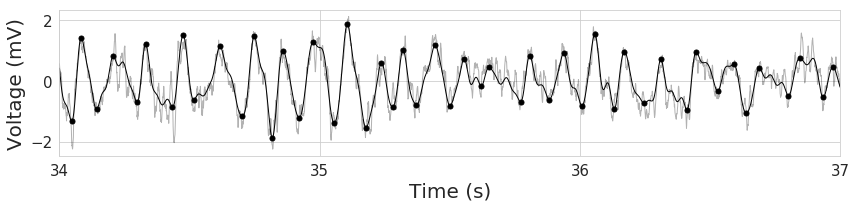

In [4]:
# Determine peak and trough times
tlim = (34, 37)
troughs = df['sample_trough'][(df['sample_trough'] > tlim[0]*Fs) &
                                    (df['sample_trough'] < tlim[1]*Fs)]
peaks = df['sample_last_peak'][(df['sample_last_peak'] > tlim[0]*Fs) &
                                    (df['sample_last_peak'] < tlim[1]*Fs)]
tidx = np.logical_and(t >= tlim[0], t <= tlim[1])

# Plot example lfp trace
plt.figure(figsize=(12,3))
plt.plot(t[tidx], lfp[tidx]/1000, 'k', alpha=.3)
plt.plot(t[tidx], lfp_filt[tidx]/1000, 'k')
plt.plot(t[troughs], lfp_filt[troughs]/1000, 'k.')
plt.plot(t[peaks], lfp_filt[peaks]/1000, 'k.')
plt.xlim(tlim)
plt.xticks(np.arange(tlim[0], tlim[1]+1))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.tight_layout()
plt.savefig('figs/1/A.png')

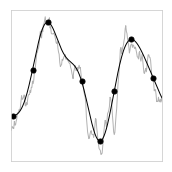

In [5]:
# Plot example lfp trace
tlim = (34.7, 34.9)
troughs = df['sample_trough'][(df['sample_trough'] > tlim[0]*Fs) &
                                    (df['sample_trough'] < tlim[1]*Fs)]
peaks = df['sample_last_peak'][(df['sample_last_peak'] > tlim[0]*Fs) &
                                    (df['sample_last_peak'] < tlim[1]*Fs)]
zeroxr = df['sample_zerox_rise'][(df['sample_zerox_rise'] > tlim[0]*Fs) &
                                    (df['sample_zerox_rise'] < tlim[1]*Fs)]
zeroxd = df['sample_zerox_decay'][(df['sample_zerox_decay'] > tlim[0]*Fs) &
                                    (df['sample_zerox_decay'] < tlim[1]*Fs)]

tidx = np.logical_and(t >= tlim[0], t <= tlim[1])
plt.figure(figsize=(2.5, 2.5))
plt.plot(t[tidx], lfp[tidx]/1000, 'k', alpha=.3)
plt.plot(t[tidx], lfp_filt[tidx]/1000, 'k')
plt.plot(t[troughs], lfp_filt[troughs]/1000, 'k.')
plt.plot(t[peaks], lfp_filt[peaks]/1000, 'k.')
plt.plot(t[zeroxr], lfp_filt[zeroxr]/1000, 'k.')
plt.plot(t[zeroxd], lfp_filt[zeroxd]/1000, 'k.')
plt.xlim(tlim)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('figs/1/B.png')

# C-F. Cycle feature distributions from example recording

In [6]:
file_shapedf = config_dict['mat_path'] + '/' + rat + '/' + sess + '/' + str(sh) + '/cycle_by_cycle_shape.csv'
df_shape = pd.read_csv(file_shapedf, index_col=0)
df_shape = df_shape[df_shape['is_burst0']].reset_index(drop=True)
df_shape['period_ms'] = df_shape['period'] / Fs * 1000
df_shape['mv_amp'] = df_shape['volt_amp'] / 1000

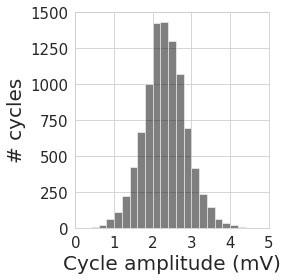

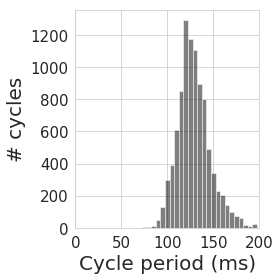

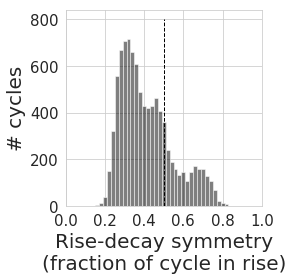

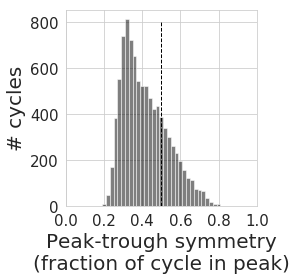

In [7]:
feats_plot = ['mv_amp', 'period_ms', 'time_rdsym', 'time_ptsym']
feat_bins = {'mv_amp': np.arange(0, 5, .2),
             'period_ms': np.arange(2.5, 200, 5),
             'time_rdsym': np.arange(.01, 1, .02),
             'time_ptsym': np.arange(.01, 1, .02)}
feat_xlim = {'mv_amp': (0,5),
             'period_ms': (0,200),
             'time_rdsym': (0,1),
             'time_ptsym': (0,1)}
feat_xticks = {'mv_amp': np.arange(6),
             'period_ms': np.arange(0,250,50),
             'time_rdsym': np.arange(0,1.2,.2),
             'time_ptsym': np.arange(0,1.2,.2)}
feat_letters = {'mv_amp': 'C',
                'period_ms': 'D',
                'time_rdsym': 'E',
                'time_ptsym': 'F'}
feat_xlabel = {'mv_amp': 'Cycle amplitude (mV)',
             'period_ms': 'Cycle period (ms)',
             'time_rdsym': 'Rise-decay symmetry\n(fraction of cycle in rise)',
             'time_ptsym': 'Peak-trough symmetry\n(fraction of cycle in peak)'}

for feat in feats_plot:
    plt.figure(figsize=(4, 4))
    plt.hist(df_shape[feat], bins=feat_bins[feat], color='k', alpha=.5)
    if feat in ['time_rdsym', 'time_ptsym']:
        plt.plot([.5, .5], [0, 800], 'k--')
    plt.xticks(feat_xticks[feat])
    plt.xlim(feat_xlim[feat])
    plt.xlabel(feat_xlabel[feat])
    plt.ylabel('# cycles')
    plt.tight_layout()
    plt.savefig('figs/1/{:s}.png'.format(feat_letters[feat]))

# G-J. Distributions of mean cycle features

In [8]:
# Quantify fraction of recordings with rise-decay and peak-trough symmetries below 0.5
print('Fraction of recordings with rise-decay symmetry < 0.5: {:.2f}'.format(np.mean(df_shanks['rdsym_mean']<0.5)))
print('Fraction of recordings with peak-trough symmetry < 0.5: {:.2f}'.format(np.mean(df_shanks['ptsym_mean']<0.5)))

Fraction of recordings with rise-decay symmetry < 0.5: 0.93
Fraction of recordings with peak-trough symmetry < 0.5: 0.95


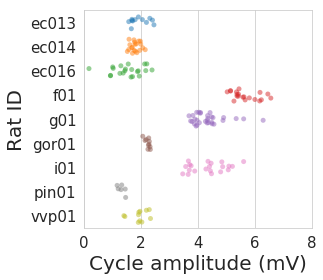

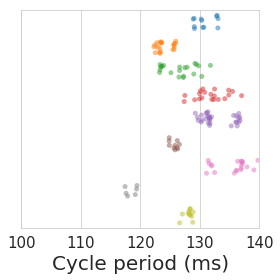

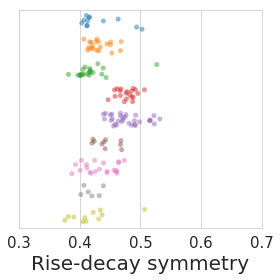

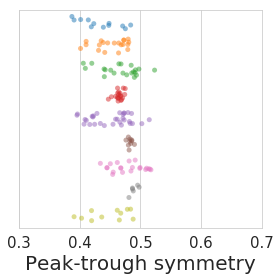

In [9]:
pltfmt = {'xticks': {'mv_amp_mean': np.arange(0,8.1,2),
                     'ms_period_mean': np.arange(100,141,10),
                     'rdsym_mean': np.arange(.3, .71, .1),
                     'ptsym_mean': np.arange(.3, .71, .1)},
          'xlabel': {'mv_amp_mean': 'Cycle amplitude (mV)',
                     'ms_period_mean': 'Cycle period (ms)',
                     'rdsym_mean': 'Rise-decay symmetry',
                     'ptsym_mean': 'Peak-trough symmetry'},
          'xlim': {'mv_amp_mean': (0, 8),
                     'ms_period_mean': (100, 140),
                     'rdsym_mean': (.3, .7),
                     'ptsym_mean': (.3, .7)},
          'letter': {'mv_amp_mean': 'G',
                     'ms_period_mean': 'H',
                     'rdsym_mean': 'I',
                     'ptsym_mean': 'J'}
         }

for feat in pltfmt['letter'].keys():
    # Compute figsize
    if feat == 'mv_amp_mean':
        figsize = (4.6,4)
    else:
        figsize = (4,4)
    plt.figure(figsize=figsize)
    
    # Make plot
    sns.stripplot(x=feat, y='rat', data=df_shanks, jitter=.3, alpha=.5)
    
    # Axis labels
    plt.xlim(pltfmt['xlim'][feat])
    plt.xlabel(pltfmt['xlabel'][feat])
    plt.xticks(pltfmt['xticks'][feat])
    if feat == 'mv_amp_mean':
        plt.ylabel('Rat ID')
    else:
        plt.ylabel('')
        plt.yticks([])

    # Save plot
    plt.tight_layout()
    plt.savefig('figs/1/{:s}.png'.format(pltfmt['letter'][feat]))